# TOMANDO EN CUENTA EL TIPO DE DATO QUE ES


In [1]:
# LIBRERIAS

# Visualizacion de datos 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ML imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# Otros
import os
from datetime import datetime

# Configura el estilo de los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5) # Tamaño por defecto para los gráficos

#Direccion de los datos Silver
SILVER_DIR = os.path.join("..", "data", "silver")
silver_file_path = os.path.join(SILVER_DIR, "silver_data.parquet")

# --- VARIABLES
VARIABLES_CONTINUAS = [
    "voltaje",
    "corriente_carga",
    "temperatura_aceite",
    "temperatura_ambiente",
    "temperatura_punto_caliente",
    "temperatura_burbujeo",
    "potencia_aparente",
]
VARIABLES_DISCRETAS = [
    "tap_position"
]
# CARGAR DATAFRAME SILVER
try:
    df_silver = pd.read_parquet(silver_file_path)
    print("DataFrame Silver cargado exitosamente.")
    display(df_silver.head(10))
except FileNotFoundError:
    print(f"Error: No se encontró el archivo Parquet en {silver_file_path}")


DataFrame Silver cargado exitosamente.


,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position
timestamp,,,,,,,,
2024-09-10 04:00:00,131.041825,739.327177,50.900000,26.500000,54.653733,178.928398,30.745757,10
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11
2024-09-10 05:15:00,130.947408,679.651644,52.871428,25.866667,57.304115,176.126086,28.242603,11
2024-09-10 05:30:00,131.011387,671.082906,52.714285,25.500000,57.232162,176.001775,27.921659,10
2024-09-10 05:45:00,131.140706,663.630621,52.557143,26.299999,56.913330,175.877464,27.625818,11
2024-09-10 06:00:00,131.046645,656.529251,52.400000,26.500000,56.749290,175.753153,27.324530,11


1. Información General del DataFrame de Silver 


Despues de los cambios realizados en la capa silver los datos se encuentran en un formato más limpio y estructurado, lo que facilita el análisis exploratorio. A continuación, se presentan algunas observaciones iniciales sobre los datos:
    - Las variables continuas como voltaje, corriente de carga y temperatura fueron interpoladas, resampleadas e imputadas para tratar el mayo numero de valores nulos despues de los cambios realizados. 
    - La variable "tap_position" es discreta por lo que se uso otro tipo de tratado de los valores nulos, forward fill y backward fill. Dejando como nulos solo los valores iniciales, que son los cuales no pudo resamplear. Para los valores faltantes se usaron tecnicas de KNN para determinar el valor mas cercano dentro de tap position  


In [ ]:
def detect_outliers_iqr(df):
    """
    Detecta outliers usando el rango intercuartil (IQR) para cada variable numérica.
    Devuelve un DataFrame con la cantidad de outliers detectados por variable.
    """
    outliers_dict = {}
    numeric_cols = df.select_dtypes(include='number').columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        #imprimir los límites inferior y superior
        print(f"Variable: {col}, Límite Inferior: {lower_bound}, límite Superior: {upper_bound}")  
        # Contar los outliers inferiores y superiores
        outliers_count_inf = df[(df[col] < lower_bound)].shape[0]
        outliers_count_sup = df[(df[col] > upper_bound)].shape[0]
        print(f"Variable: {col}, Outliers Inferiores: {outliers_count_inf}, Outliers Superiores: {outliers_count_sup}")
                            
        outliers_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
        outliers_dict[col] = outliers_count

    outliers_df = pd.DataFrame.from_dict(outliers_dict, orient='index', columns=['Outliers'])
    return outliers_df
detect_outliers_iqr(df_silver)

In [ ]:
#Valores de tap position con valor 1
tap_position_values = df_silver[df_silver['tap_position']== 1]
tap_position_values.describe()
#print(f"Valores de 'tap_position': {tap_position_values.to_dict()}")

In [ ]:
import math
(131.421407*math.sqrt(3)*1000)# Ejemplo de cálculo de la ecuacion de voltaje fase tierra en configuracion estrella

In [2]:
for col in df_silver.columns:
    #nans
    nans = df_silver[col].isna().sum()
    print(f"{col}: {nans} nans")

voltaje: 0 nans
corriente_carga: 0 nans
temperatura_aceite: 0 nans
temperatura_ambiente: 0 nans
temperatura_punto_caliente: 0 nans
temperatura_burbujeo: 0 nans
potencia_aparente: 0 nans
tap_position: 0 nans


Datos de silver procesados y sin ningun valor nulo 

In [3]:
df_silver.info()  # Información general del DataFrame 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28128 entries, 2024-09-10 04:00:00 to 2025-06-30 03:45:00
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   voltaje                     28128 non-null  float64
 1   corriente_carga             28128 non-null  float64
 2   temperatura_aceite          28128 non-null  float64
 3   temperatura_ambiente        28128 non-null  float64
 4   temperatura_punto_caliente  28128 non-null  float64
 5   temperatura_burbujeo        28128 non-null  float64
 6   potencia_aparente           28128 non-null  float64
 7   tap_position                28128 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1.9 MB


2. Estadísticas Descriptivas

In [4]:
df_silver.describe() # Descripción estadística de las variables numéricas

,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position
count,28128.000000,28128.000000,28128.000000,28128.000000,28128.000000,28128.000000,28128.000000,28128.000000
mean,130.198982,760.796581,47.718838,25.324251,53.042151,172.550834,30.604581,8.889114
std,2.406888,183.681024,6.786372,6.356597,8.525469,7.422020,7.415386,1.770683
min,117.529670,349.122867,30.100000,2.900000,33.373882,151.349197,14.525275,1.000000
25%,128.684088,630.731864,42.574999,21.133333,46.198703,167.523624,25.278148,8.000000
50%,130.318762,715.768050,47.700001,25.400000,52.252426,172.157251,28.697671,9.000000
75%,131.859987,866.702061,52.449999,29.750000,59.077466,175.882864,34.986989,10.000000
max,139.353373,1481.982067,67.000000,41.000000,80.383949,194.108917,61.422872,17.000000


Histogramas


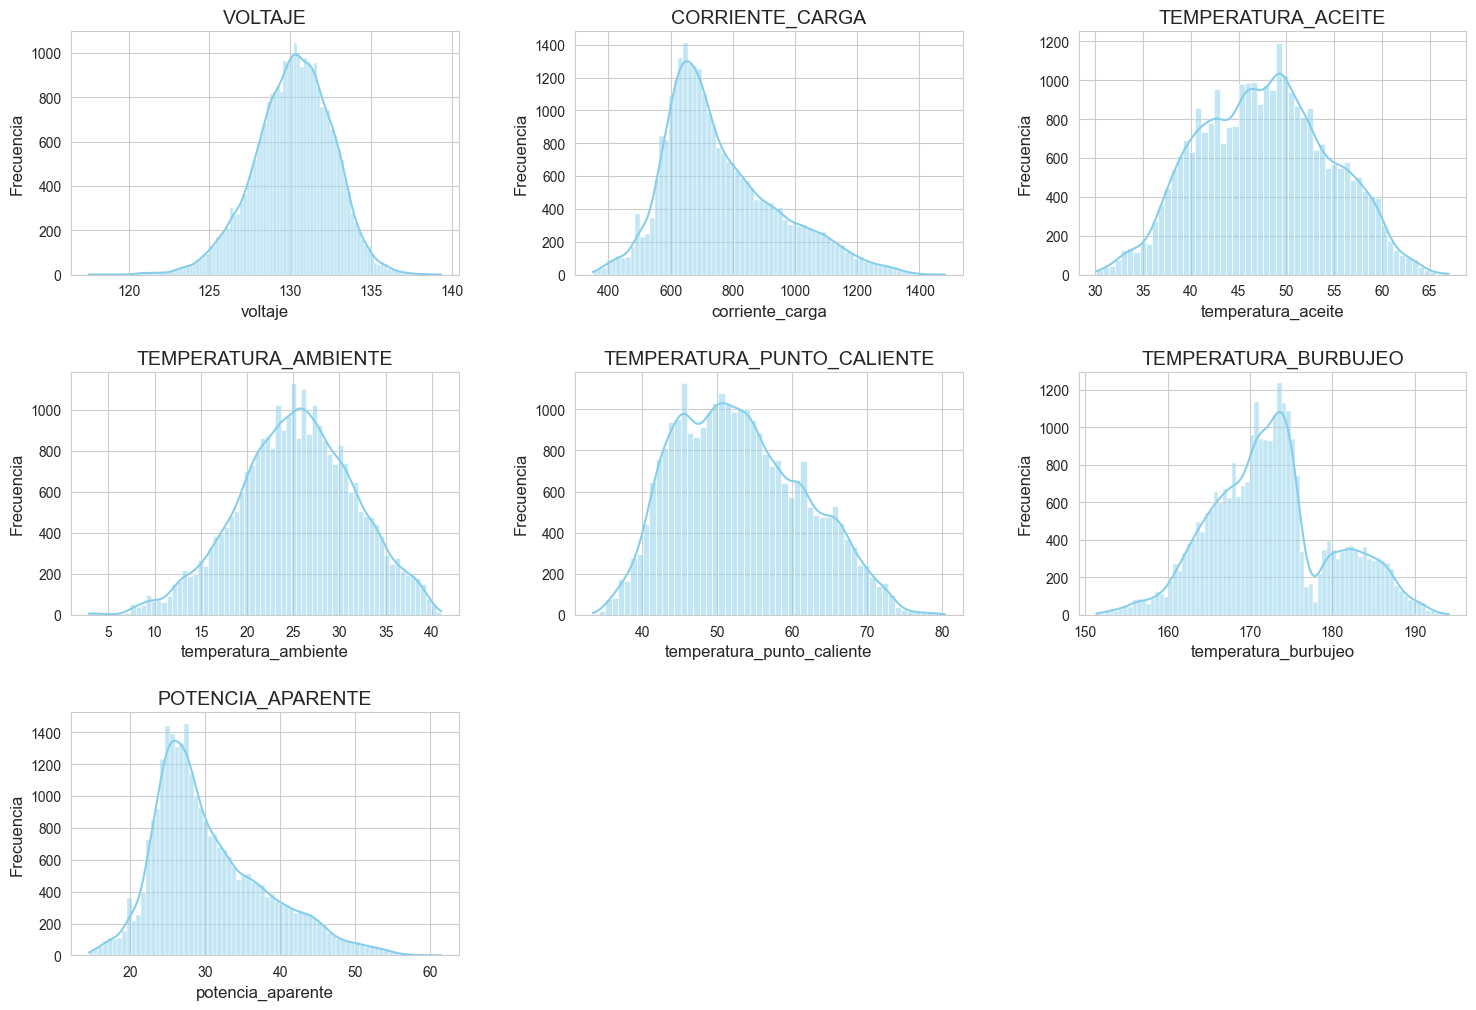

In [5]:
def plot_histograms(df: pd.DataFrame, continuous_vars: list):

    # Filtrar el DataFrame para incluir solo las variables continuas
    df_to_plot = df[continuous_vars]
    num_cols_plot =  3 # Número de columnas en el subplot
    num_rows_plot = (len(continuous_vars) + num_cols_plot - 1) // num_cols_plot
    
    # Crear subgráficos
    fig, ax = plt.subplots(nrows=num_rows_plot, ncols=num_cols_plot, figsize=(18, 4 * num_rows_plot))
    fig.subplots_adjust(hspace=0.4, wspace=0.3) # Ajustar espaciado
    ax = ax.flatten() # Aplanar el array de axes para fácil iteración
    
    # Generar gráficos individuales
    for i, col in enumerate(continuous_vars):
        sns.histplot(df_to_plot[col], kde=True, ax=ax[i], color='skyblue')
        ax[i].set_title(f'{col.upper()}', fontsize=14)
        ax[i].set_xlabel(col, fontsize=12)
        ax[i].set_ylabel('Frecuencia', fontsize=12)
      
    # # Ocultar subplots vacíos si hay un número impar de gráficos
    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])
    plt.show()

# Llamar a la función para generar los histogramas
plot_histograms(df_silver, VARIABLES_CONTINUAS)


Observaciones histograma:
voltaje: Media: 130.2 V, Rango: 117.3 – 139.4. Con una distribución: Aproximadamente normal, ligera asimetría negativa.
Interpretación: Muy buen comportamiento. El rango y la forma concuerdan con lo que se espera de un sistema regulado por tap_position.
Recomendación: No necesita transformación. Puedes mantenerlo tal cual para Gold.


Histogramas (Celda 3):

Observa la forma de las distribuciones de tus variables continuas. ¿Son simétricas, sesgadas (hacia la izquierda o derecha)? ¿Hay múltiples picos? Esto te da una idea de los rangos de valores más comunes.

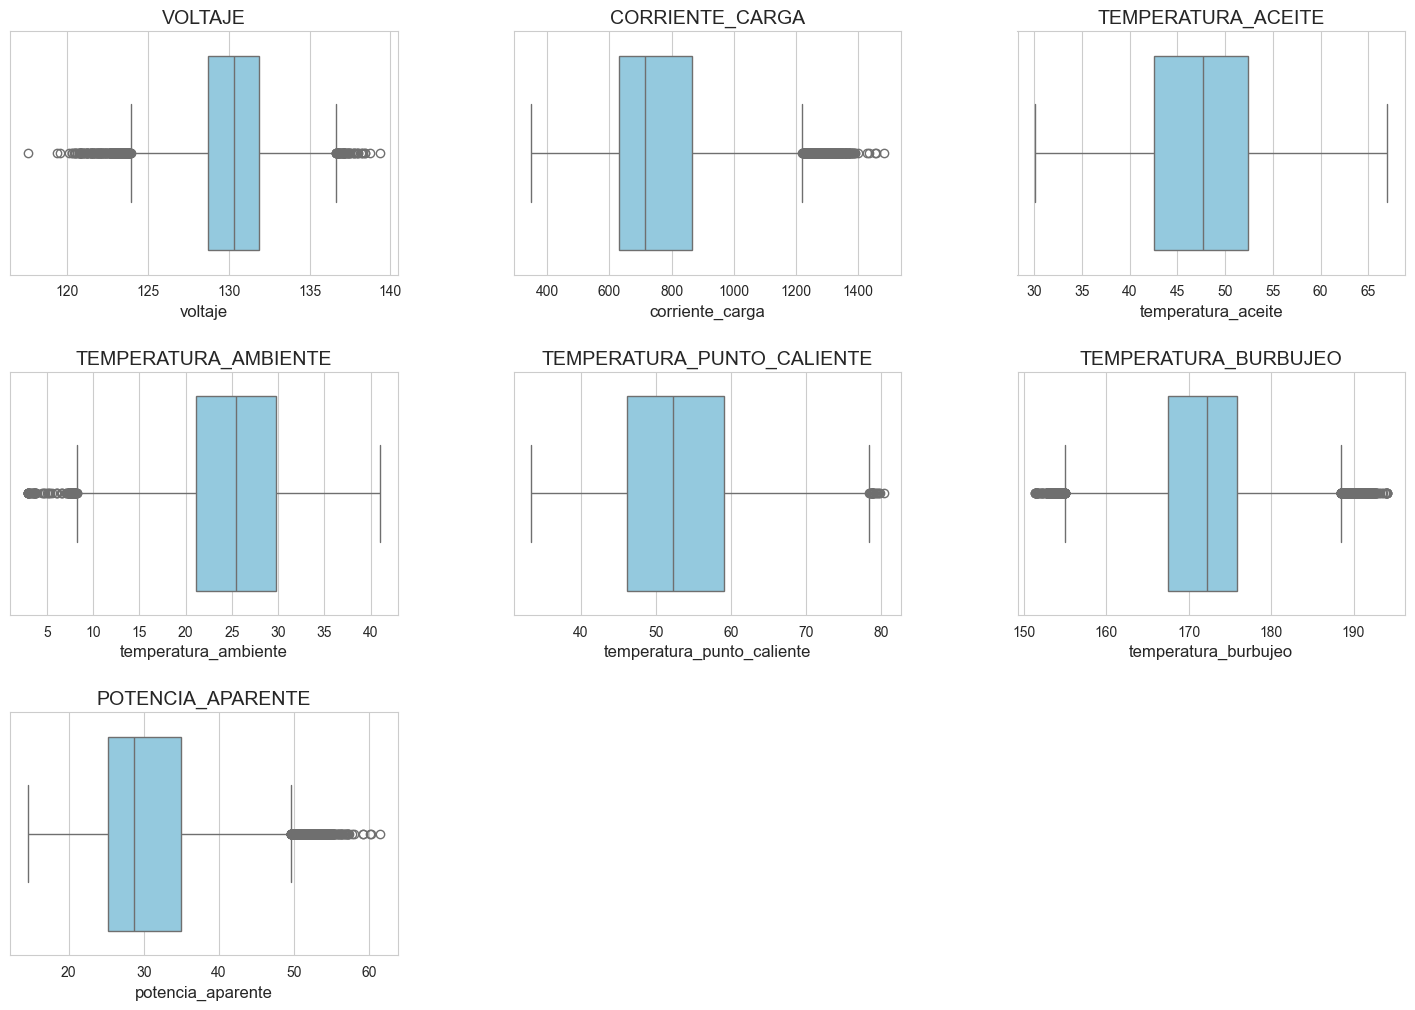

In [6]:
def plot_boxplots(df: pd.DataFrame, continuous_vars: list):
    # Filtrar el DataFrame para incluir solo las variables continuas
    df_to_plot = df[continuous_vars]

    num_cols_plot = 3  # Número de columnas en el subplot
    num_rows_plot = (len(continuous_vars) + num_cols_plot - 1) // num_cols_plot
    
    # Crear subgráficos
    fig, ax = plt.subplots(nrows=num_rows_plot, ncols=num_cols_plot, figsize=(18, 4 * num_rows_plot))
    fig.subplots_adjust(hspace=0.4, wspace=0.3) # Ajustar espaciado
    ax = ax.flatten() # Aplanar el array de axes para fácil iteración
    
    # Generar gráficos individuales
    for i, col in enumerate(continuous_vars):
        sns.boxplot(x=df_to_plot[col], ax=ax[i], color='skyblue')
        ax[i].set_title(f'{col.upper()}', fontsize=14)
        ax[i].set_xlabel(col, fontsize=12)
        
    # Ocultar subplots vacíos si hay un número impar de gráficos
    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])
    
    plt.show()

# Llamar a la función para generar los box plots
plot_boxplots(df_silver, VARIABLES_CONTINUAS)


Box Plots (Celda 4):

Estos son clave para los outliers. Cualquier punto individual que se extienda más allá de los "bigotes" del box plot es un outlier.

Observa su magnitud. ¿Son valores físicamente imposibles (lo que indicaría un error de sensor o de registro)? ¿O son valores extremos pero posibles (lo que podría ser una señal de una condición inusual o pre-falla)?

Documenta tus observaciones sobre los outliers. Esto será crucial para decidir si necesitas tratarlos en la capa Gold o si los dejas para que XGBoost los maneje.


C:\Users\Asus TUF\AppData\Local\Temp\ipykernel_4408\522890920.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col].dropna(), ax=ax[i], palette='viridis')


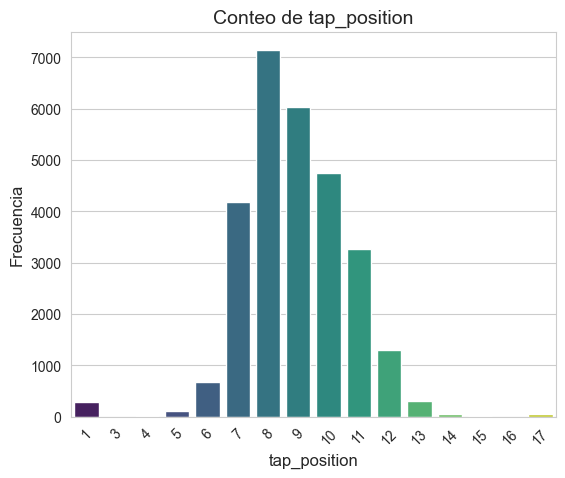

In [7]:

def plot_counts(df: pd.DataFrame, discrete_vars: list):    
    num_cols_plot = 2  # Número de columnas en el subplot (para que sean más grandes)
    num_rows_plot = (len(discrete_vars) + num_cols_plot - 1) // num_cols_plot
    
    fig, ax = plt.subplots(nrows=num_rows_plot, ncols=num_cols_plot, figsize=(15, 5 * num_rows_plot))
    fig.subplots_adjust(hspace=0.5, wspace=0.4)
    ax = ax.flatten()
    
    for i, col in enumerate(discrete_vars):
        sns.countplot(x=df[col].dropna(), ax=ax[i], palette='viridis')
        ax[i].set_title(f'Conteo de {col}', fontsize=14)
        ax[i].set_xlabel(col, fontsize=12)
        ax[i].set_ylabel('Frecuencia', fontsize=12)
        # Rotar etiquetas si son muchas categorías
        if len(df[col].unique()) > 5:
            ax[i].tick_params(axis='x', rotation=45)
      

    # Ocultar subplots vacíos
    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])
    
    plt.show()

# Llamar a la función para generar los gráficos de conteo
plot_counts(df_silver, VARIABLES_DISCRETAS)


Gráficos de Conteo (Celda 5):

Para tus variables discretas (como tap_position), ¿cuáles son las categorías más frecuentes? ¿Hay alguna categoría con muy pocos conteos? Esto es importante para entender la distribución de estados.

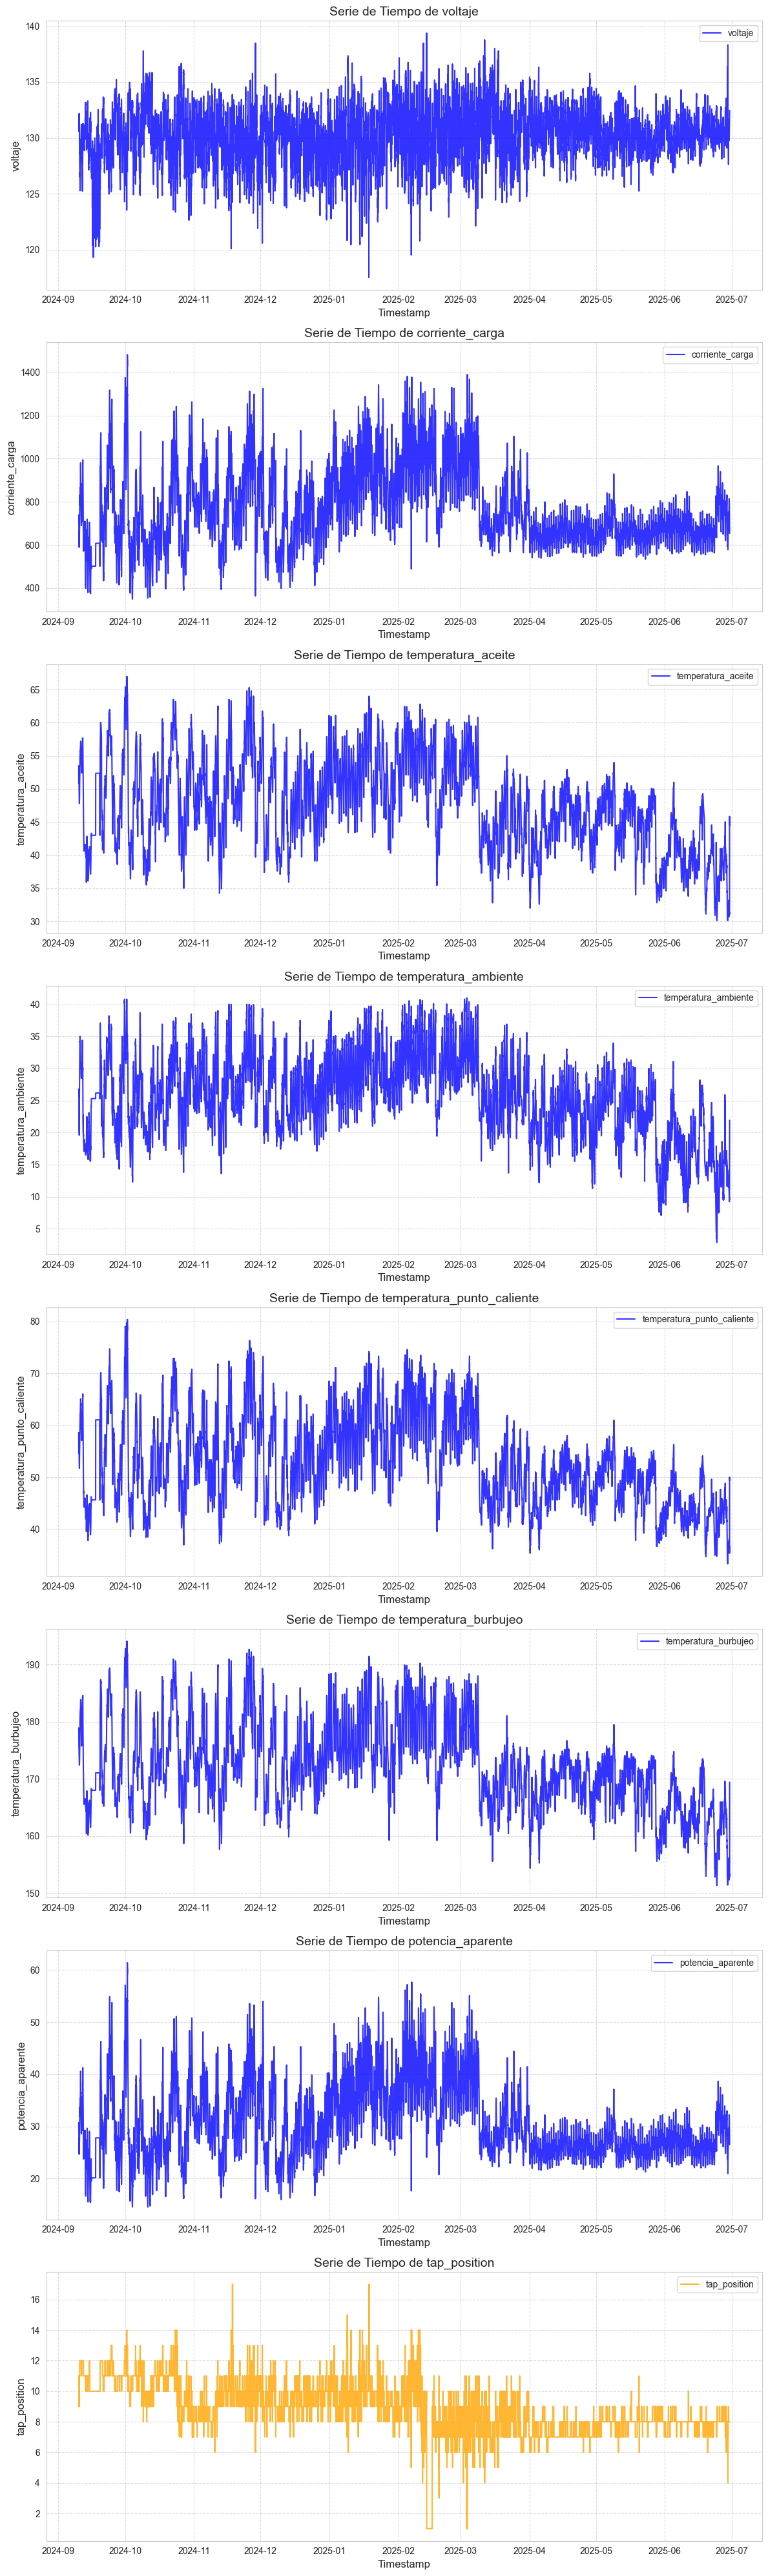

In [8]:

def plot_time_series(df: pd.DataFrame, continuous_vars: list, discrete_vars: list):

    # Seleccionar un subconjunto de datos si el DataFrame es muy grande para plotear todo.
    df_sample = df

    if not df_sample.empty:
        all_vars = continuous_vars + discrete_vars
        num_cols_ts = len(all_vars)
        num_rows_ts = num_cols_ts # 1 columna por fila para series de tiempo
        
        fig, axes = plt.subplots(nrows=num_rows_ts, ncols=1, figsize=(12, 5 * num_rows_ts))
        axes = axes.flatten() if num_rows_ts > 1 else [axes]

        for i, col in enumerate(all_vars):
            axes[i].plot(df_sample.index, df_sample[col], 
                         label=col, 
                         color='blue' if col in continuous_vars else 'orange', 
                         alpha=0.8,
                         linewidth=1.5)
            axes[i].set_title(f'Serie de Tiempo de {col}', fontsize=14)
            axes[i].set_xlabel('Timestamp', fontsize=12)
            axes[i].set_ylabel(col, fontsize=12)
            axes[i].legend(loc='upper right')
            axes[i].grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("DataFrame vacío o muestra para serie de tiempo es muy pequeña.")

# Llamar a la función para generar los gráficos de series de tiempo
plot_time_series(df_silver, VARIABLES_CONTINUAS, VARIABLES_DISCRETAS)


Series de Tiempo (Celda 6):

¿La frecuencia de 15 minutos se ve consistente?

¿Cómo se ven las interpolaciones que realizaste? ¿Son suaves y lógicas, o hay saltos extraños o "planicies" que no te parecen realistas?

¿Hay tendencias claras (crecimiento, decrecimiento) en algunas variables?

¿Observas patrones de estacionalidad (ej., ciclos diarios, semanales) en algunas variables (temperatura ambiente, potencia aparente)?

¿Cómo se ven los outliers en el contexto de la serie de tiempo? ¿Son picos aislados o parte de un patrón más grande?

Este análisis te dará una visión profunda de la calidad de tus datos en la capa Silver y te preparará para las decisiones de Feature Engineering y el posible tratamiento de outliers en la capa Gold.

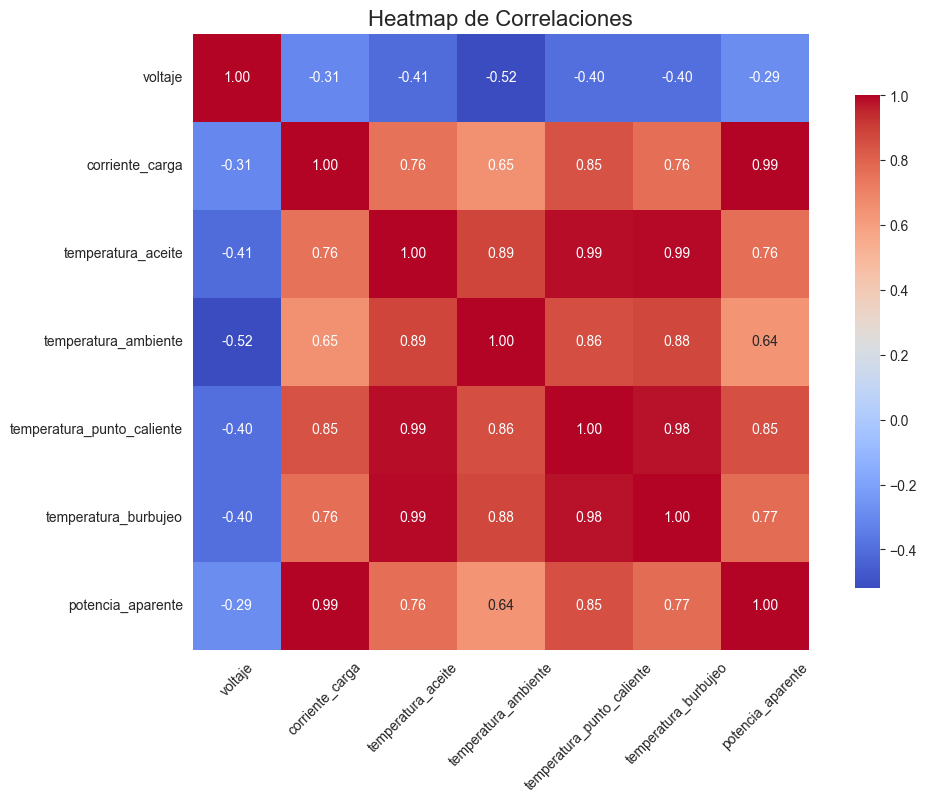

In [9]:
#funcion para graficar el heatmap de correlaciones
def plot_heatmap_correlations(df: pd.DataFrame, continuous_vars: list, figsize=(12, 8)):
    # Filtrar el DataFrame para incluir solo las variables continuas
    df_to_plot = df[continuous_vars]
    
    # Calcular la matriz de correlación
    corr_matrix = df_to_plot.corr()
    
    # Crear el heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Heatmap de Correlaciones', fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
# Llamar a la función para generar el heatmap de correlaciones
plot_heatmap_correlations(df_silver, VARIABLES_CONTINUAS)

In [ ]:
# Función corregida para gráficos de caja por categoría para variables discretas
def plot_boxplots_by_category(df: pd.DataFrame, continuous_vars: list, discrete_vars: list):
    """
    Crea boxplots de variables continuas agrupadas por variables discretas.
    Cada variable discreta genera un conjunto de boxplots para todas las variables continuas.
    """
    # Calcular el número total de gráficos necesarios
    total_plots = len(discrete_vars) * len(continuous_vars)
    
    # Configurar el layout de subplots
    num_cols_plot = 3  # Número de columnas en el subplot
    num_rows_plot = (total_plots + num_cols_plot - 1) // num_cols_plot
    
    # Crear la figura con el número correcto de subplots
    fig, axes = plt.subplots(nrows=num_rows_plot, ncols=num_cols_plot, 
                            figsize=(15, 5 * num_rows_plot))
    fig.subplots_adjust(hspace=0.5, wspace=0.4)
    
    # Convertir axes a array 1D para fácil indexación
    if num_rows_plot == 1 and num_cols_plot == 1:
        axes = [axes]
    elif num_rows_plot == 1 or num_cols_plot == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Índice para rastrear la posición actual del subplot
    plot_idx = 0
    
    # Generar gráficos para cada combinación de variable discreta y continua
    for i, cat_col in enumerate(discrete_vars):
        for j, cont_col in enumerate(continuous_vars):
            if plot_idx < len(axes):
                try:
                    # Crear el boxplot
                    sns.boxplot(x=df[cat_col], y=df[cont_col], 
                              hue=df[cat_col],  # Asignar la misma variable del eje x
                              ax=axes[plot_idx], 
                              palette='viridis',
                              legend=False)
                    
                    # Configurar títulos y etiquetas
                    axes[plot_idx].set_title(f'{cont_col} por {cat_col}', fontsize=14)
                    axes[plot_idx].set_xlabel(cat_col, fontsize=12)
                    axes[plot_idx].set_ylabel(cont_col, fontsize=12)
                    
                    # Rotar etiquetas si hay muchas categorías
                    if len(df[cat_col].unique()) > 5:
                        axes[plot_idx].tick_params(axis='x', rotation=45)
                    
                    plot_idx += 1
                    
                except Exception as e:
                    print(f"Error al crear gráfico para {cont_col} por {cat_col}: {str(e)}")
                    plot_idx += 1

    # Ocultar subplots vacíos
    for idx in range(plot_idx, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# Llamar a la función para generar los gráficos de caja por categoría
plot_boxplots_by_category(df_silver, VARIABLES_CONTINUAS, VARIABLES_DISCRETAS)

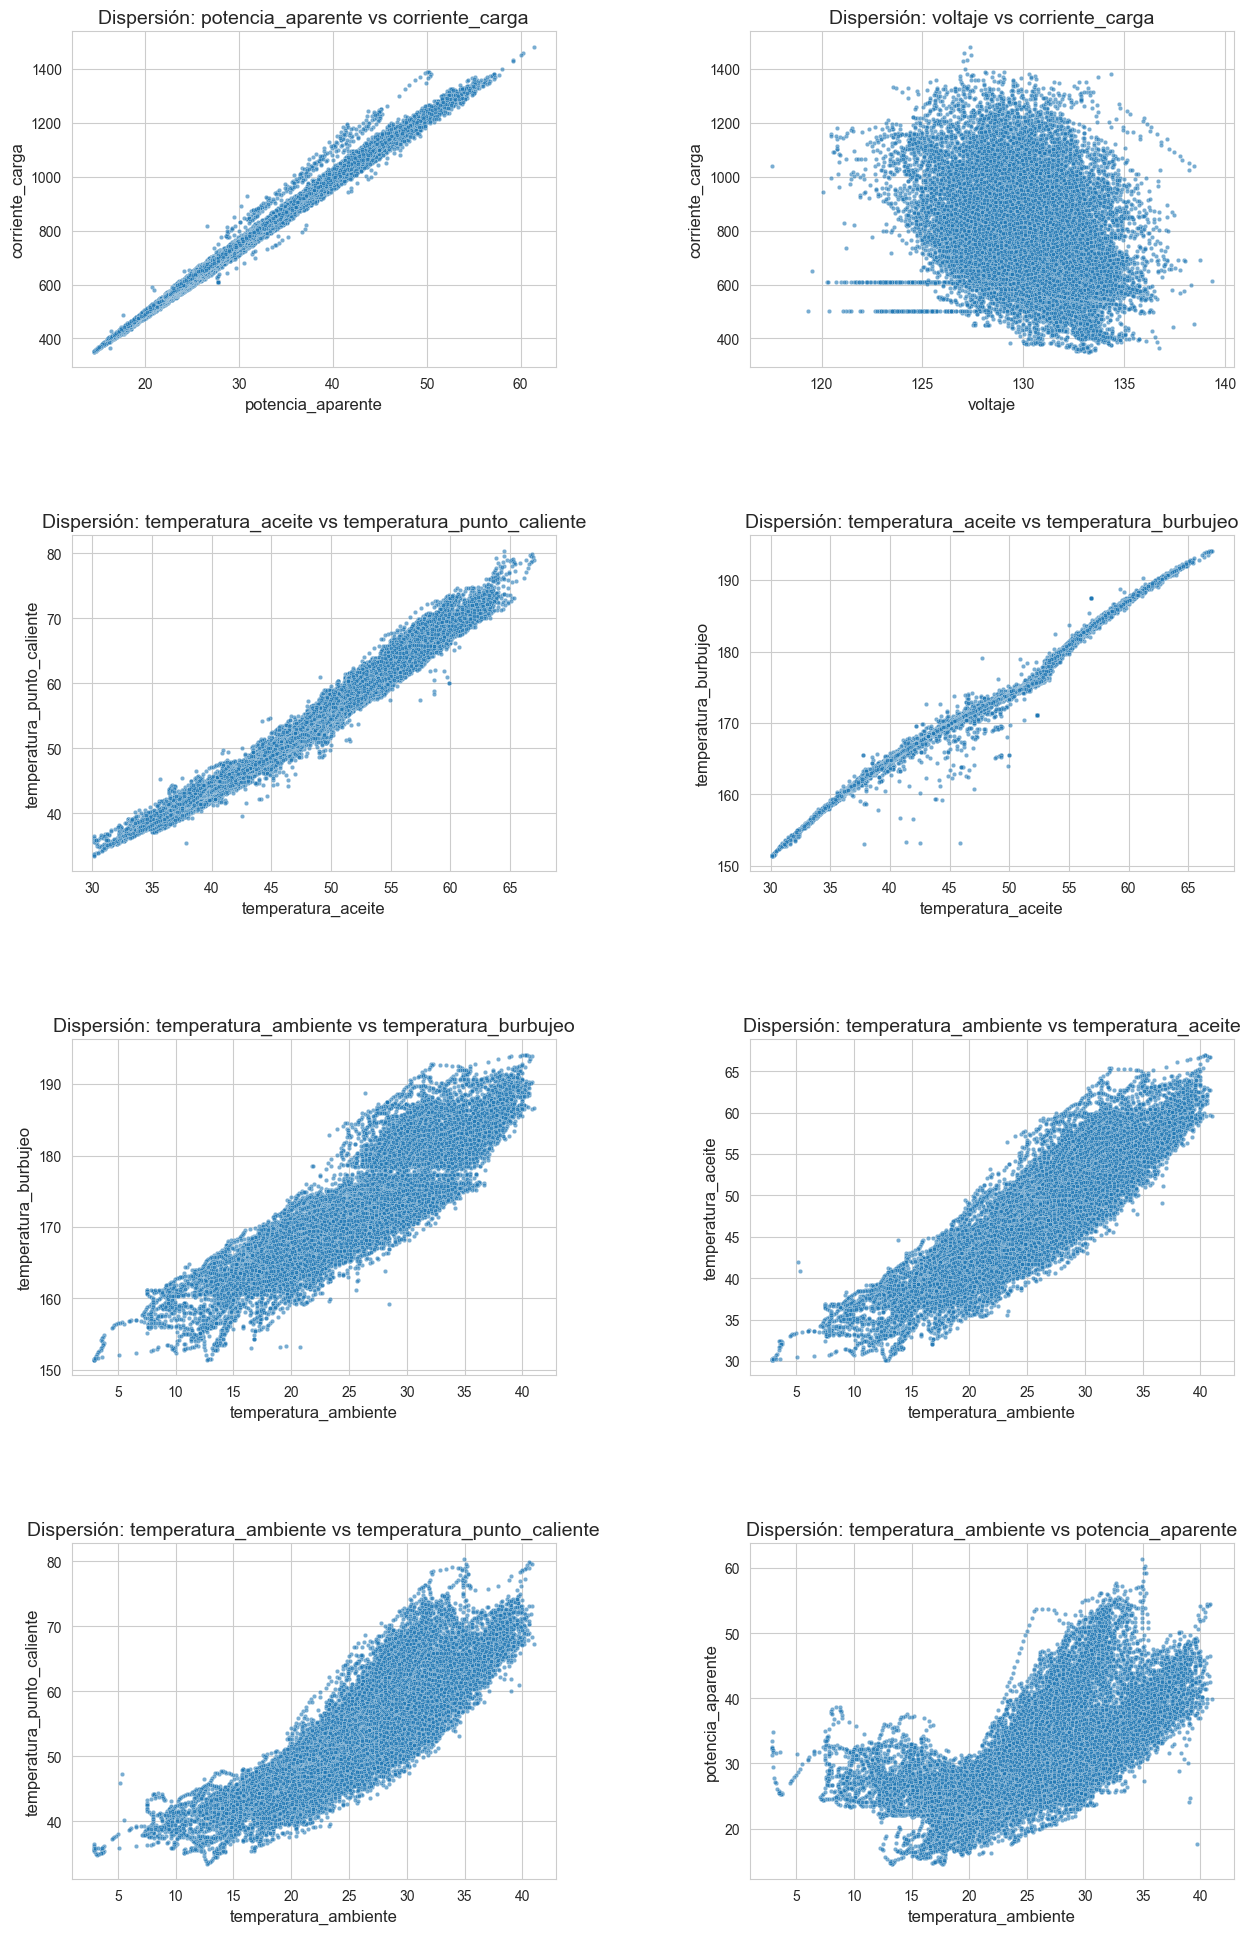

In [11]:
# etl/eda_silver_layer_notebook.ipynb - Celda 6: Gráficos de Dispersión

def plot_scatter_continuous(df: pd.DataFrame, continuous_vars: list):
    relevant_pairs = []
    relevant_pairs.append(("potencia_aparente", "corriente_carga"))
    relevant_pairs.append(("voltaje", "corriente_carga"))
    
    relevant_pairs.append(("temperatura_aceite", "temperatura_punto_caliente"))
    relevant_pairs.append(("temperatura_aceite", "temperatura_burbujeo"))
    relevant_pairs.append(("temperatura_ambiente", "temperatura_burbujeo"))
    relevant_pairs.append(("temperatura_ambiente", "temperatura_aceite"))
    relevant_pairs.append(("temperatura_ambiente", "temperatura_punto_caliente"))
    relevant_pairs.append(("temperatura_ambiente", "potencia_aparente"))

    num_plots = len(relevant_pairs)
    num_cols_plot = 2 # 2 columnas por fila
    num_rows_plot = (num_plots + num_cols_plot - 1) // num_cols_plot    
    fig, axes = plt.subplots(nrows=num_rows_plot, ncols=num_cols_plot, figsize=(15, 6 * num_rows_plot))
    fig.subplots_adjust(hspace=0.5, wspace=0.4)
    axes = axes.flatten()
    
    for i, (x_col, y_col) in enumerate(relevant_pairs):
        if x_col in df.columns and y_col in df.columns:
            # Eliminar NaNs solo para el par de columnas actual para el ploteo
            df_pair = df[[x_col, y_col]].dropna()
            if not df_pair.empty:
                sns.scatterplot(x=df_pair[x_col], y=df_pair[y_col], ax=axes[i], alpha=0.6, s=10) # s es tamaño de los puntos
                axes[i].set_title(f'Dispersión: {x_col} vs {y_col}', fontsize=14)
                axes[i].set_xlabel(x_col, fontsize=12)
                axes[i].set_ylabel(y_col, fontsize=12)
            else:
                axes[i].set_title(f'Dispersión: {x_col} vs {y_col} (Sin datos válidos)', fontsize=14)
                axes[i].text(0.5, 0.5, 'No hay datos para mostrar', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        else:
            axes[i].set_title(f'Columnas {x_col} o {y_col} no encontradas', fontsize=14)
            axes[i].text(0.5, 0.5, 'Error de columna', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)

    # Ocultar subplots vacíos
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

# Llamar a la función para generar los gráficos de dispersión
plot_scatter_continuous(df_silver, VARIABLES_CONTINUAS)


In [ ]:
#DBSCAN
# etl/eda_silver_layer_notebook.ipynb - Celda 8: Detección de Outliers Multivariados con DBSCAN

if not df_silver.empty and VARIABLES_CONTINUAS: # DBSCAN se aplica mejor a variables continuas

    df_dbscan = df_silver[VARIABLES_CONTINUAS].copy()
    initial_rows = len(df_dbscan)
    df_dbscan.dropna(inplace=True) # DBSCAN no puede trabajar con NaNs
    rows_after_dropna = len(df_dbscan)
    if initial_rows != rows_after_dropna:
        print(f"Advertencia: Se eliminaron {initial_rows - rows_after_dropna} filas con NaNs para DBSCAN.")
    
    if df_dbscan.empty:
        print("DataFrame para DBSCAN está vacío después de eliminar NaNs. No se puede ejecutar DBSCAN.")
    else:
        # 2. Escalar los datos
        # StandardScaler es adecuado para DBSCAN ya que centra los datos y los escala a varianza unitaria.
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df_dbscan)
        
        print(f"Datos escalados para DBSCAN. Dimensiones: {X_scaled.shape}")

        # 3. Aplicar DBSCAN
        # Parámetros clave:
        # - eps: La distancia máxima entre dos muestras para que una sea considerada como en la vecindad de la otra.
        # - min_samples: El número de muestras (o puntos) en una vecindad para que un punto sea considerado un punto central.
        #        Un valor común es 2 * número_de_dimensiones, o simplemente 5-10.
        # --- AJUSTA ESTOS PARÁMETROS SEGÚN TUS DATOS Y OBSERVACIONES ---
        # Si eps es muy pequeño, muchos puntos serán ruido. Si es muy grande, todo será un clúster.
        # Si min_samples es mu
        # y pequeño, se formarán muchos clústeres pequeños.
        eps_value = 0.5 # Ejemplo: ajusta este valor
        min_samples_value = len(VARIABLES_CONTINUAS) * 2 # Ejemplo: ajusta este valor (ej. 2 * num_features)

        print(f"Ejecutando DBSCAN con eps={eps_value}, min_samples={min_samples_value}...")
        dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
        clusters = dbscan.fit_predict(X_scaled)

        # 4. Analizar los resultados de DBSCAN
        df_dbscan['cluster'] = clusters
        
        # Los puntos con cluster -1 son considerados outliers (ruido)
        outliers_dbscan = df_dbscan[df_dbscan['cluster'] == -1]
        
        print(f"\nResultados de DBSCAN:")
        print(f"Número de clústeres encontrados: {len(np.unique(clusters)) - (1 if -1 in clusters else 0)}")
        print(f"Número de outliers detectados (cluster -1): {len(outliers_dbscan)}")
        print(f"Porcentaje de outliers: {len(outliers_dbscan) / len(df_dbscan) * 100:.2f}%")

        if not outliers_dbscan.empty:
            print("\nEjemplos de outliers detectados por DBSCAN (primeras 5 filas):")
            display(outliers_dbscan.head())
            
            # Opcional: Visualizar outliers en un gráfico de dispersión (si tienes 2 o 3 variables)
            if len(VARIABLES_CONTINUAS) >= 2:
                print("\nVisualizando outliers de DBSCAN (primeras 2 variables continuas):")
                plt.figure(figsize=(10, 7))
                sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=clusters, palette='viridis', s=15, alpha=0.7)
                plt.title(f'DBSCAN Clusters y Outliers (eps={eps_value}, min_samples={min_samples_value})', fontsize=16)
                plt.xlabel(f'Variable Escalada 1 ({VARIABLES_CONTINUAS[0]})', fontsize=12)
                plt.ylabel(f'Variable Escalada 2 ({VARIABLES_CONTINUAS[1]})', fontsize=12)
                plt.legend(title='Cluster')
                plt.show()
                print("Los puntos con color distinto o aislados suelen ser los outliers (-1).")
            else:
                print("Se necesitan al menos 2 variables continuas para visualizar los clusters de DBSCAN.")
        else:
            print("No se detectaron outliers por DBSCAN con los parámetros actuales.")

else:
    print("DataFrame vacío o no hay variables continuas para ejecutar DBSCAN.")


In [ ]:
import pandas as pd 
df_capas=pd.read_parquet('../data/silver/silver_data.parquet')
df_capas.head()

In [ ]:

def filtrar_outliers_iqr_con_rango(df):
    """
    Filtra outliers de cada variable numérica usando el método IQR y muestra
    los rangos mínimo y máximo después de filtrar.
    """
    df_filtrado = df.copy()
    numeric_cols = df.select_dtypes(include='number').columns

    rangos = {}

    for col in numeric_cols:
        Q1 = df_filtrado[col].quantile(0.25)
        Q3 = df_filtrado[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_filtrado = df_filtrado[(df_filtrado[col] >= lower_bound) & (df_filtrado[col] <= upper_bound)]

        # Guardar el rango limpio
        rango_min = df_filtrado[col].min()
        rango_max = df_filtrado[col].max()
        rangos[col] = (rango_min, rango_max)

    return df_filtrado, rangos

# Uso:
dfclean, rangos = filtrar_outliers_iqr_con_rango(df_capas)

# Mostrar rangos
for col, (min_val, max_val) in rangos.items():
    print(f"Variable: {col} -> Min: {min_val:.2f}, Max: {max_val:.2f}")


In [ ]:
import matplotlib.pyplot as plt

def graficar_limites_control_todas(df):
    """Grafica los límites de control (LCL y UCL) para todas las columnas numéricas del DataFrame."""
    columnas_numericas = df.select_dtypes(include='number').columns
    
    for col in columnas_numericas:
        data = df[col].dropna()
        mean_val = data.mean()
        std_val = data.std()
        ucl = mean_val + 3 * std_val
        lcl = mean_val - 3 * std_val

        plt.figure(figsize=(10, 4))
        plt.plot(data.values, label=col, color='blue')
        plt.axhline(ucl, color='red', linestyle='--', label='UCL')
        plt.axhline(mean_val, color='green', linestyle='-', label='Mean')
        plt.axhline(lcl, color='red', linestyle='--', label='LCL')
        plt.title(f'Límites de Control - {col}')
        plt.xlabel('Índice')
        plt.ylabel('Valor')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

graficar_limites_control_todas(df_capas)

In [ ]:
import math 
198/math.sqrt(3)

voltaje 